# Journo-Jobs

Being an accurate representation of the analysis required for our Journo-Jobs paper at Future of Journalism 2017

In [275]:
%matplotlib inline

# import some things we need

# stdlib
import re
import os
import csv
import json
from datetime import datetime
from collections import defaultdict, Counter

#external libraries
import spacy
import textacy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# set some settings for MatPlotLib plots
# plt.style.use('seaborn-whitegrid')
mpl.rcdefaults()
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (14,10)
mpl.rcParams['axes.grid'] = True

# nlp with spacy
nlp = spacy.load('en')


In [268]:
# then we define the things we need

DATA_DIR = os.path.join(os.getcwd(), os.pardir, 'data')
print(DATA_DIR)

OUTPUT_DIR = os.path.join(os.getcwd(), os.pardir, 'output')
print(OUTPUT_DIR)

CSV_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'csv')
print(CSV_OUTPUT_DIR)

FIGURE_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'figures')
print(FIGURE_OUTPUT_DIR)

JSON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'json')
print(JSON_OUTPUT_DIR)

for directory in [OUTPUT_DIR, CSV_OUTPUT_DIR, FIGURE_OUTPUT_DIR, JSON_OUTPUT_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def pprint_json(json_obj):
    print(json.dumps(json_obj, sort_keys=True, indent=4, ensure_ascii=False))  

/Users/martin/Dropbox/Coding/curop-jobs/analysis/../data
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output/csv
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output/figures
/Users/martin/Dropbox/Coding/curop-jobs/analysis/../output/json


## Loading the data

First we need to read the list of json files in the directory, then read the data in

In [5]:
file_names = [f for f in os.listdir(DATA_DIR) if f.endswith('.json')]
print(file_names)

['gorkana_2017-Apr-07--17-40-02.json', 'gorkana_2017-Apr-14--17-40-02.json', 'gorkana_2017-Apr-21--17-40-02.json', 'gorkana_2017-Apr-28--17-40-02.json', 'gorkana_2017-Aug-04--17-40-02.json', 'gorkana_2017-Aug-11--17-40-02.json', 'gorkana_2017-Aug-18--17-40-02.json', 'gorkana_2017-Feb-03--17-40-02.json', 'gorkana_2017-Feb-10--17-40-02.json', 'gorkana_2017-Feb-17--17-40-02.json', 'gorkana_2017-Feb-24--17-40-02.json', 'gorkana_2017-Jul-07--17-40-02.json', 'gorkana_2017-Jul-14--17-40-02.json', 'gorkana_2017-Jul-21--17-40-02.json', 'gorkana_2017-Jul-28--17-40-02.json', 'gorkana_2017-Jun-02--17-40-02.json', 'gorkana_2017-Jun-09--17-40-02.json', 'gorkana_2017-Jun-16--17-40-02.json', 'gorkana_2017-Jun-23--17-40-02.json', 'gorkana_2017-Jun-30--17-40-02.json', 'gorkana_2017-Mar-03--17-40-02.json', 'gorkana_2017-Mar-10--17-40-02.json', 'gorkana_2017-Mar-17--17-40-02.json', 'gorkana_2017-Mar-24--17-40-02.json', 'gorkana_2017-Mar-31--17-40-02.json', 'gorkana_2017-May-05--17-40-02.json', 'gorkana_20

Of course, we didn't use an ISO standard when we wrote the date into the filename because we're not that clever. Lets split the filename up into the source and the date, and read the files into a data structure, organised by source, then date. We'll print the count for each source and date, just for info

In [37]:
DATE_FORMAT = '%Y-%b-%d--%H-%M-%S'

source2date2jobs = defaultdict(dict)
dates = set()

for f in file_names:
    f_str = f.replace('.json', '')
    first_underscore = f_str.find('_')
    source = f_str[:first_underscore]
    print(source)
    date_string = f_str[first_underscore+1:]
    print(date_string)
    f_date = datetime.strptime(date_string, DATE_FORMAT)
    print(f_date)
    f_date_only = f_date.date()
    print(f_date_only)
    source2date2jobs[source][f_date_only] = json.load(open(os.path.join(DATA_DIR, f), 'r'))
    dates.add(f_date_only)

for source, dates in source2date2jobs.items():
    for date, jobs in source2date2jobs[source].items():
        print(source, date, len(jobs))

gorkana
2017-Apr-07--17-40-02
2017-04-07 17:40:02
2017-04-07
gorkana
2017-Apr-14--17-40-02
2017-04-14 17:40:02
2017-04-14
gorkana
2017-Apr-21--17-40-02
2017-04-21 17:40:02
2017-04-21
gorkana
2017-Apr-28--17-40-02
2017-04-28 17:40:02
2017-04-28
gorkana
2017-Aug-04--17-40-02
2017-08-04 17:40:02
2017-08-04
gorkana
2017-Aug-11--17-40-02
2017-08-11 17:40:02
2017-08-11
gorkana
2017-Aug-18--17-40-02
2017-08-18 17:40:02
2017-08-18
gorkana
2017-Feb-03--17-40-02
2017-02-03 17:40:02
2017-02-03
gorkana
2017-Feb-10--17-40-02
2017-02-10 17:40:02
2017-02-10
gorkana
2017-Feb-17--17-40-02
2017-02-17 17:40:02
2017-02-17
gorkana
2017-Feb-24--17-40-02
2017-02-24 17:40:02
2017-02-24
gorkana
2017-Jul-07--17-40-02
2017-07-07 17:40:02
2017-07-07
gorkana
2017-Jul-14--17-40-02
2017-07-14 17:40:02
2017-07-14
gorkana
2017-Jul-21--17-40-02
2017-07-21 17:40:02
2017-07-21
gorkana
2017-Jul-28--17-40-02
2017-07-28 17:40:02
2017-07-28
gorkana
2017-Jun-02--17-40-02
2017-06-02 17:40:02
2017-06-02
gorkana
2017-Jun-09--17-

In [43]:

# write out one file per source of jobs

headers = ['date', 'count']
for source, dates in source2date2jobs.items():
    
    source_data = []
    with open(os.path.join(CSV_OUTPUT_DIR, '%s.csv' % source), 'w') as output_file:
    
        writer = csv.DictWriter(output_file, headers)
        writer.writeheader()
        for date, jobs in source2date2jobs[source].items():
            source_data.append({'date': date, 'count': len(jobs)})
        writer.writerows(source_data)
        

def get_num_jobs_for_date(data, source, date):
    return len(data[source][date]) if data[source].get(date) else 0
        
        
# write a combined file
headers = ['date', 'htfp', 'gorkana', 'journalism']
rows = []
with open(os.path.join(CSV_OUTPUT_DIR, 'combined_count.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for date in dates:
        row = {
               'date': date, 
               'htfp': get_num_jobs_for_date(source2date2jobs, 'htfp', date),
               'gorkana': get_num_jobs_for_date(source2date2jobs, 'gorkana', date),
               'journalism': get_num_jobs_for_date(source2date2jobs, 'journalism', date)
              }
        rows.append(row)
    writer.writerows(rows)

    
    
        

In [50]:
# read in our combined data
combined_data = pd.read_csv(os.path.join(CSV_OUTPUT_DIR, 'combined_count.csv'), index_col=0, parse_dates=True)
combined_data = combined_data.sort_index()
print(combined_data)

            htfp  gorkana  journalism
date                                 
2017-02-02    55        0          69
2017-02-03    63      222          69
2017-02-10    71      211          73
2017-02-17    61      211          56
2017-02-24    47      193          63
2017-03-03    50      176          56
2017-03-10    48      165          61
2017-03-17    50      164          65
2017-03-24    49      161          62
2017-03-31    48      197          63
2017-04-07    48      189          70
2017-04-21    38      187          62
2017-04-28    43      190          70
2017-05-05    37      186          55
2017-05-12    47      200          58
2017-05-19    49      212          75
2017-05-26    53      201          70
2017-06-02    47      195          73
2017-06-09    54      205          66
2017-06-16    48      204          55
2017-06-23    45      203          50
2017-06-30    40      215          45
2017-07-07    36      208          55
2017-07-14    37      200          45
2017-07-21  

In [322]:
start_date = datetime.strptime('2017-02-02', '%Y-%m-%d')
end_date = datetime.strptime('2017-08-18', '%Y-%m-%d')

duration = end_date - start_date
print(duration)

197 days, 0:00:00


In [71]:
print(plt.style.available)

['classic', 'seaborn-darkgrid', 'seaborn-ticks', 'seaborn-paper', 'dark_background', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-poster', 'ggplot', 'seaborn-dark', 'seaborn-muted', 'seaborn-deep', 'seaborn-notebook', 'seaborn-bright', 'seaborn', 'bmh', '_classic_test', 'fivethirtyeight', 'grayscale', 'seaborn-whitegrid', 'seaborn-talk', 'seaborn-pastel', 'seaborn-white']


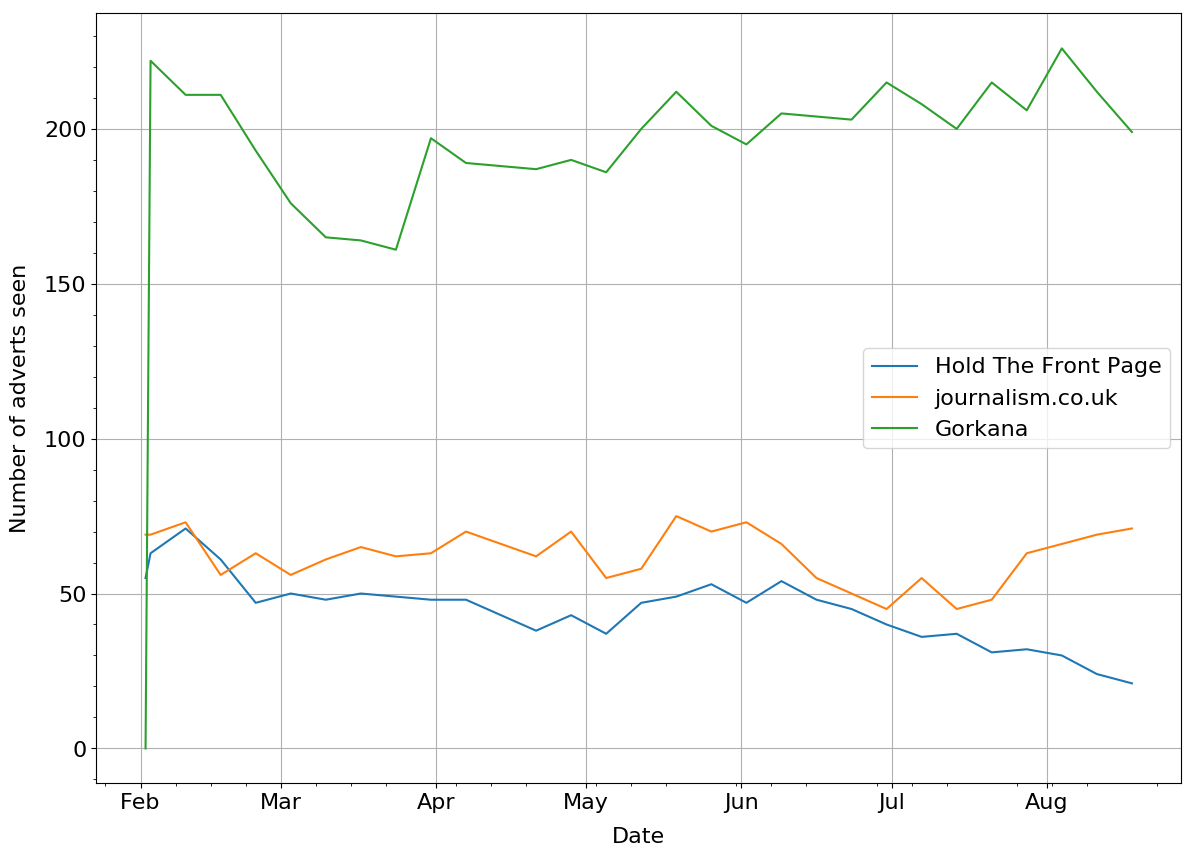

In [126]:
fig, ax = plt.subplots()

date_format = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(date_format)
ax.minorticks_on()
ax.set_ylabel('Number of adverts seen', labelpad=10)
ax.set_xlabel('Date', labelpad=10)

ax.plot(combined_data.index, combined_data['htfp'], label='Hold The Front Page')
ax.plot(combined_data.index, combined_data['journalism'], label='journalism.co.uk')
ax.plot(combined_data.index, combined_data['gorkana'], label='Gorkana')

ax.legend()
plt.show()


Of course, some of these adverts will be duplicates, and will be repeated from week to week, so we need to reduce to unique adverts only

In [136]:
# let's have a look at an advert from gorkana

a_job = source2date2jobs['gorkana'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))

{
    "Details": "\nPOLITICO is looking for experienced editors to join a dynamic group of journalists in Brussels and beyond. Ideal candidates will have sharp hands-on editing skills, a passion for digital journalism and proven leadership skills.\n\r\nThese are busy, hands-on editing jobs that will involve close coordination with teams in Brussels and across Europe to produce quality articles for a sophisticated readership on POLITICO.eu, our PRO subscription service and the weekly paper edition.\n\nQualifications\nExperienced editor or senior reporter/correspondent; knowledge of European politics and policy; strong English-language writing and editing skills; ability to work under pressure and on deadline; knowledge of other European languages is a plus.\n\nEqual Opportunity\n\nIt is POLITICO's policy to provide equal employment opportunity to all qualified individuals without regard to race, color, religion, national origin, gender, age or any other characteristic protected by local

In [132]:
# let's have a look at an advert from journalism

a_job = source2date2jobs['journalism'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))

{
    "Details": "The Sun's digital team is growing, and we want the most talented and committed digital journalists to join us.\nThe successful candidate will:\n\n\nAct as a daily go-to person for journalists and reporters seeking advice or improvements to articles\n\n\nReport each morning on the top SEO keywords driving traffic\n\n\nMake recommendations to journalists for relevant keywords and keyword combinations to target on articles\n\n\nReport each morning on top pages/articles driving SEO traffic\n\n\nPre-plan for future articles and events by building out topics and doing keyword research for upcoming exclusives or events e.g. Olympics\n\n\nMonitor trending data for newsroom suggestions and pass to editorial desks\n\n\nOptimise top pages for relevant keywords\n\n\nForward link top traffic driving pages to other more recent articles to encourage circulation\n\n\nMonitor daily output and ensure relevant cross linking in articles e.g. ensure 2 other articles links in copy, relevan

In [138]:
# let's have a look at an advert from htfp

a_job = source2date2jobs['htfp'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))

{
    "Details": "Job Description\n\nCaters News is looking for a brilliant reporter to join the team at our global headquarters in Birmingham, UK.\nOur journalists fill the pages of national newspapers with top-quality stories every day, and we’re on the hunt for a reporter who can hit the ground running.\nWe’re looking for a real ‘people-person’ who can start up a conversation with anyone, and get even the most reluctant interviewee to open up.\nIf you’re a switched-on, creative, and ambitious journalist who wants to see your stories published in media outlets across the globe, then it’s the ideal opportunity.\nAs with all the best jobs in journalism, having a thick skin and a sense of humour is also helpful.\nSuccessful candidates will be joining a fun, creative team with a real buzz – and an opportunity to really make a name for yourself.\nYou’ll need to have an NCTJ qualification, as well as your own transport and a driving licence.\nThe ideal candidate will have experience at an 

In [178]:
# let's enrich the jobs by adding their source and the date they were seen, and replace the newline characters with whitespace

for source, dates in source2date2jobs.items():
    for date, jobs in source2date2jobs[source].items():
        for job in jobs:
            job['DateSeen'] = date.strftime('%Y-%m-%d')
            job['Source'] = source
            job['Details'] = job['Details'].replace('\n', ' ')
            job['link'] = job['link'].split('?')[0]
            
a_job = source2date2jobs['htfp'][list(dates)[0]][0]
print(json.dumps(a_job, sort_keys=True, indent=4, ensure_ascii=False))            

{
    "DateSeen": "2017-03-10",
    "Details": "Job Description  Caters News is looking for a brilliant reporter to join the team at our global headquarters in Birmingham, UK. Our journalists fill the pages of national newspapers with top-quality stories every day, and we’re on the hunt for a reporter who can hit the ground running. We’re looking for a real ‘people-person’ who can start up a conversation with anyone, and get even the most reluctant interviewee to open up. If you’re a switched-on, creative, and ambitious journalist who wants to see your stories published in media outlets across the globe, then it’s the ideal opportunity. As with all the best jobs in journalism, having a thick skin and a sense of humour is also helpful. Successful candidates will be joining a fun, creative team with a real buzz – and an opportunity to really make a name for yourself. You’ll need to have an NCTJ qualification, as well as your own transport and a driving licence. The ideal candidate will h

In [179]:
count = defaultdict(int)

for source, dates in source2date2jobs.items():
    for date, jobs in source2date2jobs[source].items():
        count[source] += len(jobs)
print(count)
        

defaultdict(<class 'int'>, {'gorkana': 5740, 'journalism': 1883, 'htfp': 1302})


In [180]:
duplicate_jobs_removed_by_url = {}

for source, dates in source2date2jobs.items():
    duplicate_jobs_removed_by_url[source] = []
    for date, jobs in source2date2jobs[source].items():
        for job in jobs:
            existing_links = [j['link'] for j in duplicate_jobs_removed_by_url[source]]
            if not job['link'] in existing_links:
                duplicate_jobs_removed_by_url[source].append(job)
    print(source, len(duplicate_jobs_removed_by_url[source]))
    
for source, jobs in duplicate_jobs_removed_by_url.items():
    with open(os.path.join(JSON_OUTPUT_DIR, '%s.json' % source), 'w') as output_file:
        json.dump(jobs, output_file, ensure_ascii=False, indent=4, sort_keys=True)
    
            

gorkana 1671
journalism 535
htfp 429


In [189]:
%%time

def find_matches(combined_jobs, duplicates, jobs_to_check):
    
    for this_job in jobs_to_check:
        match = False
        for that_job in combined_jobs:
            # check the similarity between the role title as a whole item
            role_ratio = fuzz.ratio(this_job['Role'], that_job['Role'])
            
            # only do further processing if the role is the same
            if role_ratio > 97:
                
                # check the similarity between the job details - can tokenize this and treat it as a bag of words
                details_ratio = fuzz.token_set_ratio(this_job['Details'], that_job['Details'])

                # if the similarities are high, we may have a match
                if details_ratio > 90:

                    # lets check the date - if they're seen more than a month after one another it
                    # may be a re-posting of the same job (or job description) so we need to count it
                    this_job_date = datetime.strptime(this_job['DateSeen'], '%Y-%m-%d')
                    that_job_date = datetime.strptime(that_job['DateSeen'], '%Y-%m-%d')

                    if this_job_date < that_job_date:
                        difference = that_job_date - this_job_date
                    else:
                        difference = this_job_date - that_job_date

                    if difference.days < 31:
                        duplicates.append((this_job, that_job))
                        match = True

                        print('\nMATCH!*********************')
                        print(difference)
                        print(this_job['Role'], this_job['link'])
                        print(that_job['Role'], that_job['link'])
                        break

        if not match:
            combined_jobs.append(this_job)
    
    return combined_jobs, duplicates

            

combined_jobs, duplicates = find_matches([], [], duplicate_jobs_removed_by_url['gorkana'])
print(len(combined_jobs), len(duplicates))
combined_jobs, duplicates = find_matches(combined_jobs, duplicates, duplicate_jobs_removed_by_url['htfp'])
print(len(combined_jobs), len(duplicates))
combined_jobs, duplicates = find_matches(combined_jobs, duplicates, duplicate_jobs_removed_by_url['journalism'])
print(len(combined_jobs), len(duplicates))




MATCH!*********************
0:00:00
Reporter, MarketWatch - NY http://www.gorkanajobs.co.uk/job/68490/reporter-marketwatch-ny/
Reporter, MarketWatch - NY http://www.gorkanajobs.co.uk/job/68013/reporter-marketwatch-ny/

MATCH!*********************
28 days, 0:00:00
Reporter, The Bond Buyer - VA http://www.gorkanajobs.co.uk/job/70416/reporter-the-bond-buyer-va/
Reporter, The Bond Buyer - VA http://www.gorkanajobs.co.uk/job/67997/reporter-the-bond-buyer-va/

MATCH!*********************
28 days, 0:00:00
The Sun, SEO Editor http://www.gorkanajobs.co.uk/job/69352/the-sun-seo-editor/
The Sun, SEO Editor http://www.gorkanajobs.co.uk/job/68436/the-sun-seo-editor/

MATCH!*********************
28 days, 0:00:00
Senior Staff Writer http://www.gorkanajobs.co.uk/job/69152/senior-staff-writer/
Senior Staff Writer http://www.gorkanajobs.co.uk/job/68092/senior-staff-writer/

MATCH!*********************
28 days, 0:00:00
BusinessBecause, Intern - Graduate Journalism / Editorial Opportunity http://www.gork


MATCH!*********************
28 days, 0:00:00
Senior Reporter http://www.holdthefrontpage.co.uk/jobsboard/view/senior-reporter-grantham/
Senior Reporter http://www.holdthefrontpage.co.uk/jobsboard/view/senior-reporter-kings-lynn/

MATCH!*********************
28 days, 0:00:00
Video Producer http://www.holdthefrontpage.co.uk/jobsboard/view/video-producer-cardiff/
Video Producer http://www.holdthefrontpage.co.uk/jobsboard/view/video-producer-guildford-2/

MATCH!*********************
28 days, 0:00:00
Trainee Video Journalist http://www.holdthefrontpage.co.uk/jobsboard/view/trainee-video-journalist-glasgow/
Trainee Video Journalist http://www.holdthefrontpage.co.uk/jobsboard/view/trainee-video-journalist-guildford/

MATCH!*********************
28 days, 0:00:00
Content Editor http://www.holdthefrontpage.co.uk/jobsboard/view/content-editor-redhill-2/
Content Editor http://www.holdthefrontpage.co.uk/jobsboard/view/content-editor-redhill-3/

MATCH!*********************
0:00:00
Video Reporter ht


MATCH!*********************
28 days, 0:00:00
Reporter https://www.journalism.co.uk/media-jobs/reporter-/s75/a698182/
Reporter https://www.journalism.co.uk/media-jobs/reporter-/s75/a700262/

MATCH!*********************
28 days, 0:00:00
Business Editor https://www.journalism.co.uk/media-jobs/business-editor/s75/a699134/
Business Editor http://www.holdthefrontpage.co.uk/jobsboard/view/business-editor-leeds-2/

MATCH!*********************
0:00:00
Head of Digital Content and Engagement https://www.journalism.co.uk/media-jobs/head-of-digital-content-and-engagement/s75/a699014/
Head of Digital Content and Engagement http://www.holdthefrontpage.co.uk/jobsboard/view/head-of-digital-content-and-engagement-preston/

MATCH!*********************
28 days, 0:00:00
Broadcast journalist https://www.journalism.co.uk/media-jobs/broadcast-journalist/s75/a698181/
Broadcast journalist https://www.journalism.co.uk/media-jobs/broadcast-journalist/s75/a700051/

MATCH!*********************
0:00:00
G10 Foreign 

In [191]:
with open(os.path.join(JSON_OUTPUT_DIR, 'duplicates.json'), 'w') as output_file:
    json.dump(duplicates, output_file, ensure_ascii=False, indent=4, sort_keys=True)
    
with open(os.path.join(JSON_OUTPUT_DIR, 'combined_jobs.json'), 'w') as output_file:
    json.dump(combined_jobs, output_file, ensure_ascii=False, indent=4, sort_keys=True)
    


# End of filtering?

So now we've filtered the data down and extracted all the duplicates, let's check the totals again:

In [197]:
job_count = Counter()
date_count = Counter()
source2datecount = defaultdict(Counter)

for job in combined_jobs:
    
    job_count[job['Source']] += 1
    source2datecount[job['Source']][job['DateSeen']] += 1
    date_count[job['DateSeen']] += 1
    
print(job_count)
print(date_count)

Counter({'gorkana': 1643, 'journalism': 513, 'htfp': 392})
Counter({'2017-05-26': 319, '2017-02-10': 318, '2017-07-07': 290, '2017-08-04': 280, '2017-03-10': 273, '2017-04-07': 263, '2017-05-05': 104, '2017-05-19': 87, '2017-06-30': 79, '2017-08-18': 75, '2017-08-11': 62, '2017-02-03': 59, '2017-06-23': 40, '2017-03-17': 40, '2017-04-28': 30, '2017-02-02': 29, '2017-02-17': 26, '2017-07-28': 24, '2017-06-16': 23, '2017-03-31': 21, '2017-04-14': 19, '2017-07-14': 19, '2017-02-24': 18, '2017-05-12': 11, '2017-04-21': 10, '2017-06-09': 9, '2017-06-02': 8, '2017-03-24': 6, '2017-03-03': 4, '2017-07-21': 2})


In [199]:
# write a combined file
headers = ['date', 'count']
rows = []
with open(os.path.join(CSV_OUTPUT_DIR, 'combined_date_count.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for date, count in date_count.items():
        row = {
               'date': date, 
               'count': count
              }
        rows.append(row)
    writer.writerows(rows)

headers = ['date', 'total', 'gorkana', 'htfp', 'journalism']
rows = []
    
with open(os.path.join(CSV_OUTPUT_DIR, 'combined_date_count_by_source.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for date, count in date_count.items():
        row = {
                'date': date, 
                'total': count,
                'gorkana': source2datecount['gorkana'][date],
                'htfp': source2datecount['htfp'][date],
                'journalism': source2datecount['journalism'][date],
              }
        rows.append(row)
    writer.writerows(rows)

In [201]:
# read in our combined data
deduped_data = pd.read_csv(os.path.join(CSV_OUTPUT_DIR, 'combined_date_count_by_source.csv'), index_col=0, parse_dates=True)
deduped_data = deduped_data.sort_index()
print(deduped_data)

            total  gorkana  htfp  journalism
date                                        
2017-02-02     29        0    14          15
2017-02-03     59       59     0           0
2017-02-10    318      199    58          61
2017-02-17     26       19     6           1
2017-02-24     18        8     6           4
2017-03-03      4        2     2           0
2017-03-10    273      164    48          61
2017-03-17     40       19    11          10
2017-03-24      6        3     2           1
2017-03-31     21       16     1           4
2017-04-07    263      169    35          59
2017-04-14     19       16     0           3
2017-04-21     10        1     9           0
2017-04-28     30       20     8           2
2017-05-05    104       65    12          27
2017-05-12     11       10     0           1
2017-05-19     87       52    16          19
2017-05-26    319      201    50          68
2017-06-02      8        3     4           1
2017-06-09      9        4     2           3
2017-06-16

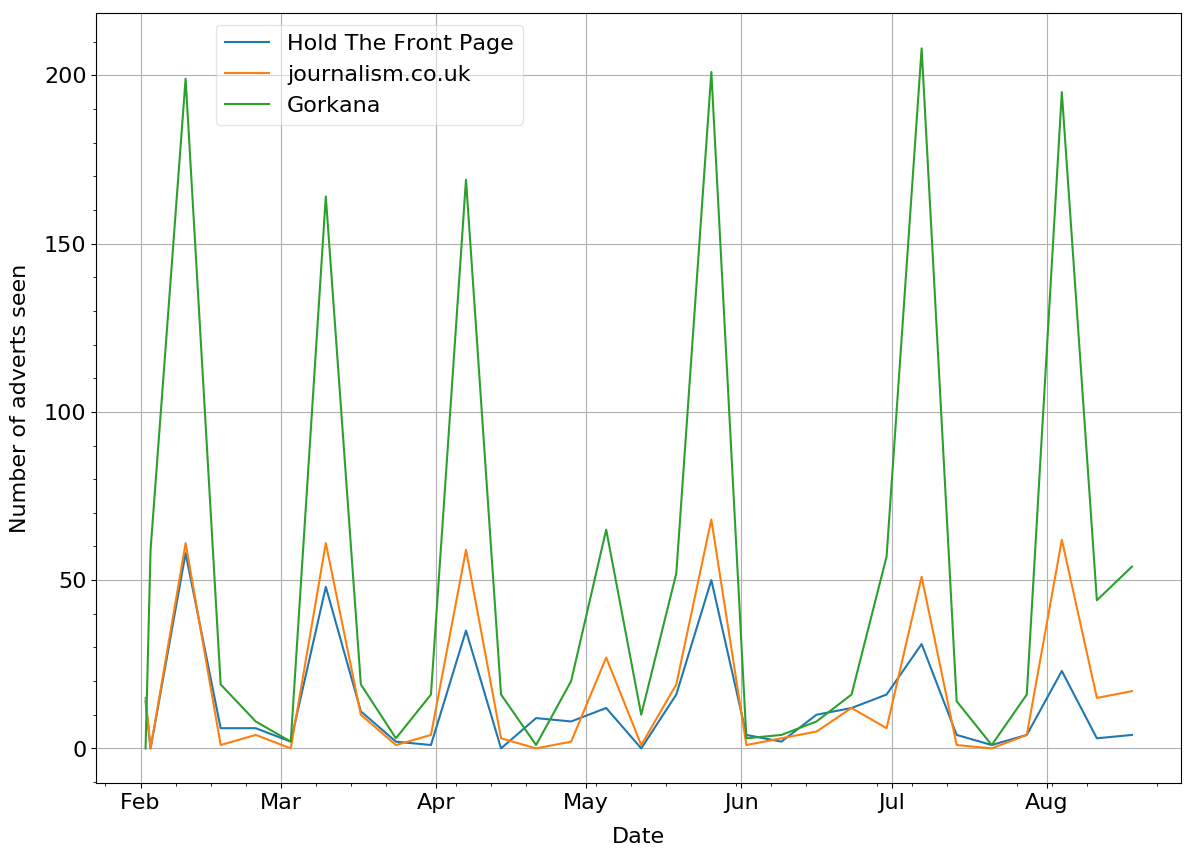

In [210]:
fig, ax = plt.subplots()

date_format = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(date_format)
ax.minorticks_on()
ax.set_ylabel('Number of adverts seen', labelpad=10)
ax.set_xlabel('Date', labelpad=10)

ax.plot(deduped_data.index, deduped_data['htfp'], label='Hold The Front Page')
ax.plot(deduped_data.index, deduped_data['journalism'], label='journalism.co.uk')
ax.plot(deduped_data.index, deduped_data['gorkana'], label='Gorkana')

ax.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0), framealpha=0.5)
plt.show()

In [213]:
role_count = Counter()

for job in combined_jobs:
    role_count[job['Role']] += 1
    
print(role_count.most_common(100))

[('Reporter', 62), ('Trainee Reporter', 39), ('Senior Reporter', 27), ('Editor', 25), ('Journalist', 17), ('Editorial assistant', 10), ('Deputy editor', 10), ('Chief Reporter', 8), ('News Editor', 8), ('Deputy Editor', 7), ('Assistant editor', 7), ('Content Editor', 7), ('Reporters', 7), ('Multimedia Journalist', 6), ('News editor', 6), ('Multimedia Reporter', 6), ('Staff writer', 6), ('Senior reporter', 5), ('Deputy News Editor', 5), ('News reporter', 5), ('News Reporter', 5), ('Photographer', 5), ("What's On Writer", 4), ('Production editor', 4), ('Which?, (Senior) Researcher / Writer', 4), ('Trainee Reporters', 4), ('Multimedia Journalist (Trainee)', 4), ('Best, Celebrity Editor', 3), ('Sub-editor', 3), ('MailOnline, Community Moderator', 3), ('Trainee Digital Journalist', 3), ('Broadcast journalist', 3), ('Mirror Online, Senior Reporter - Celebrity & TV', 3), ('RN, Reporter', 3), ('Video Journalist', 3), ('Feature Writer', 3), ('Ink, Creative Solutions Designer', 3), ('Trainee Mult

In [247]:
# Role is usually full of other information, so if we can, let's remove it

role_count = Counter()

rows = []

headers = ['source', 'original', 'corrected']
    
with open(os.path.join(CSV_OUTPUT_DIR, 'roles.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()

    for job in combined_jobs:

        role = job['Role']

        # some gorkana jobs are "role, organisation - state" so remove these first if present
        if job['Source'] == 'gorkana':
            role = re.sub(', [\w\s]+ - ([A-Z]{2})', '', role)
            # or in one case
            role = re.sub(', [\w\s]+ - [Hong Kong]+', '', role)
        
        # other jobs (including other gorkana) are "organisation, role", 
        # so remove the employer/organisation if it's there
        splits = role.split(',')
        if len(splits) > 1:
            # journalism.co.uk is "role, organisation"
            if job['Source'] == 'journalism':
                role = splits[0]
            # everything else is "organisation, role"
            else:
                role = splits[1]
        else:
            role = splits[0]

        if role.find('('):
            role = role.split('(')[0]
            
        if role.find(' - '):
            role = role.split(' - ')[0]      

        role_count[role.strip().rstrip('s').lower()] += 1

        rows.append({
            'source': job['Source'],
            'original': job['Role'],
            'corrected': role
        })
    
    writer.writerows(rows)
    
print(role_count.most_common(50))

rows = []

headers = ['role', 'count']
    
with open(os.path.join(CSV_OUTPUT_DIR, 'roles_count.csv'), 'w') as output_file:
    
    writer = csv.DictWriter(output_file, headers)
    writer.writeheader()
    
    for role, count in role_count.items():
        rows.append({
            'role': role,
            'count': count
        })
    writer.writerows(rows)

[('reporter', 168), ('editor', 118), ('deputy editor', 57), ('senior reporter', 56), ('editorial assistant', 54), ('trainee reporter', 45), ('news editor', 43), ('news reporter', 33), ('journalist', 32), ('sub-editor', 32), ('staff writer', 30), ('assistant editor', 29), ('production editor', 26), ('features writer', 17), ('editor-in-chief', 17), ('content editor', 17), ('digital editor', 16), ('features editor', 14), ('associate editor', 13), ('managing editor', 12), ('copy editor', 12), ('designer', 11), ('junior designer', 11), ('art editor', 11), ('chief reporter', 11), ('multimedia journalist', 11), ('art director', 10), ('financial journalist', 9), ('assistant news editor', 9), ('head of content', 8), ('deputy news editor', 8), ('data journalist', 8), ('sub editor', 8), ('junior reporter', 8), ('digital producer', 8), ('business editor', 8), ('senior editor', 7), ('writer', 7), ('trainee news reporter', 7), ('copywriter', 7), ('market reporter', 6), ('intern', 6), ('commissioning

In [252]:
role_data = pd.read_csv(os.path.join(CSV_OUTPUT_DIR, 'roles_count.csv'), index_col=0)
role_data.sort_values(by='count', inplace=True, ascending=False)
print(role_data)

                                                    count
role                                                     
reporter                                              168
editor                                                118
deputy editor                                          57
senior reporter                                        56
editorial assistant                                    54
trainee reporter                                       45
news editor                                            43
news reporter                                          33
journalist                                             32
sub-editor                                             32
staff writer                                           30
assistant editor                                       29
production editor                                      26
content editor                                         17
editor-in-chief                                        17
features write

In [324]:
single_adverts = role_data.loc[role_data['count'] == 1]
print(single_adverts.size)

784


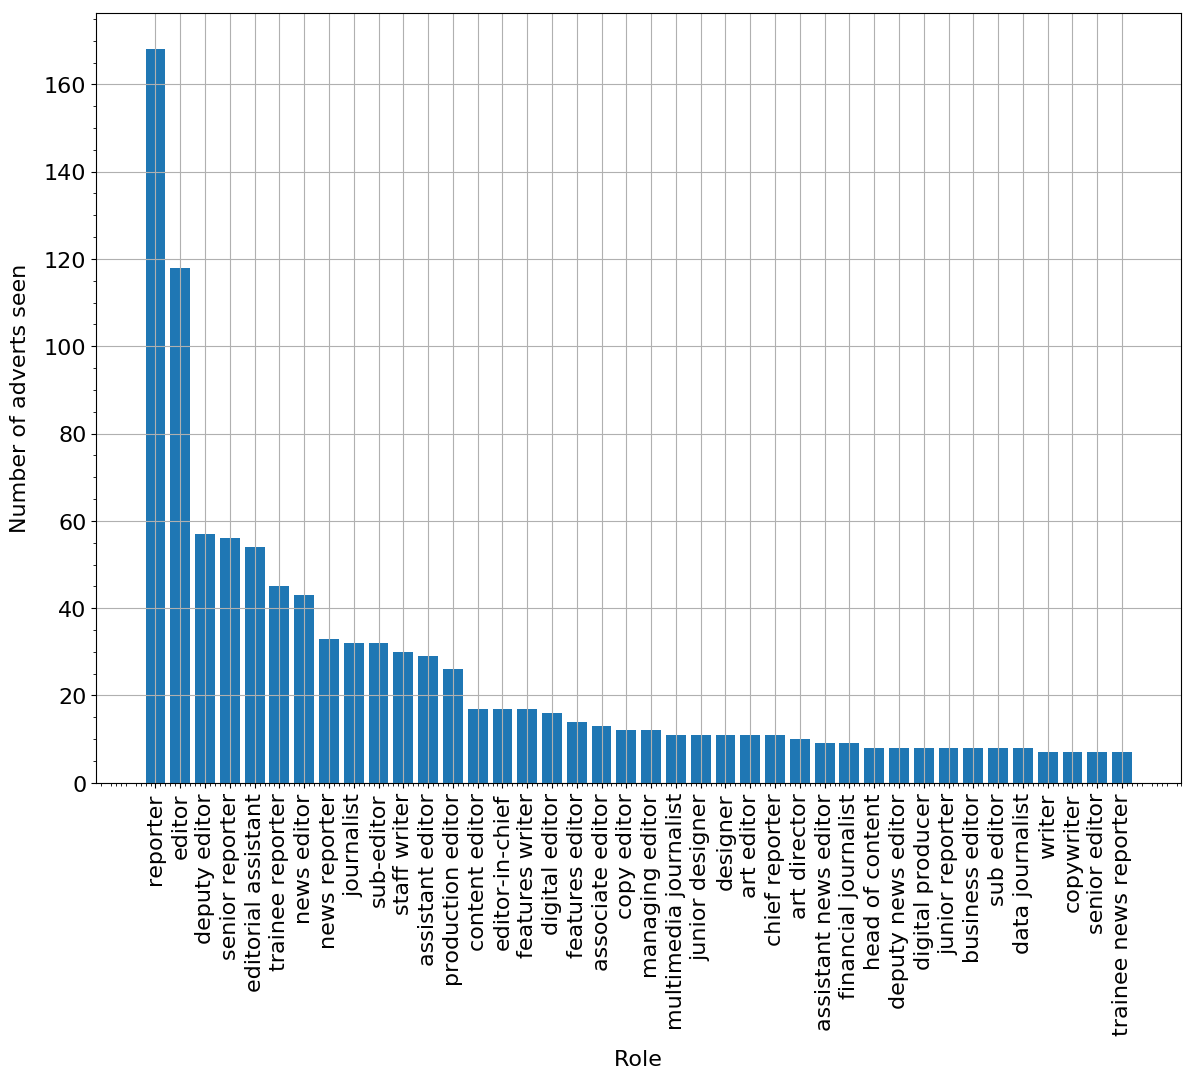

In [264]:
num_bars = 40

fig, ax = plt.subplots()

ax.minorticks_on()
ax.set_ylabel('Number of adverts seen', labelpad=10)
ax.set_xlabel('Role', labelpad=10)

ax.bar(np.arange(num_bars), role_data['count'][:num_bars])
ax.set_xticks(np.arange(num_bars))
ax.set_xticklabels(role_data.index[:num_bars], rotation=90)

#ax.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0), framealpha=0.5)
plt.show()

In [269]:
job = combined_jobs[0]
pprint_json(job)

{
    "DateSeen": "2017-03-10",
    "Details": " POLITICO is looking for experienced editors to join a dynamic group of journalists in Brussels and beyond. Ideal candidates will have sharp hands-on editing skills, a passion for digital journalism and proven leadership skills. \r These are busy, hands-on editing jobs that will involve close coordination with teams in Brussels and across Europe to produce quality articles for a sophisticated readership on POLITICO.eu, our PRO subscription service and the weekly paper edition.  Qualifications Experienced editor or senior reporter/correspondent; knowledge of European politics and policy; strong English-language writing and editing skills; ability to work under pressure and on deadline; knowledge of other European languages is a plus.  Equal Opportunity  It is POLITICO's policy to provide equal employment opportunity to all qualified individuals without regard to race, color, religion, national origin, gender, age or any other characteristi

In [278]:
doc = nlp(job['Details'])
doc = textacy.Doc(doc, lang='en')
print(doc)
# for ent in doc.ents:
#     print(ent.label_, ent.text)

Doc(226 tokens; " POLITICO is looking for experienced editors to...")


In [279]:
ad = textacy.extract.acronyms_and_definitions(doc)
print(ad)

{'CV': '', 'POLITICO': '', 'PRO': '', 'POLITICO.eu': ''}


In [ ]:
all_ads_ad = Counter()
for job in combined_jobs

In [320]:
bot = doc.to_bag_of_terms(as_strings=True)
print(bot)

{'experienced editor': 2, 'consider': 1, 'produce quality article': 1, 'paper': 1, 'service': 1, 'quality': 1, 'subscription service': 1, 'european politic': 1, 'form': 1, 'ability': 1, 'gender': 1, 'ideal candidate': 1, 'writing and editing': 1, 'journalist in brussels': 1, 'application': 3, 'paper edition': 1, "'s": 1, 'journalism and prove': 1, 'consider complete application': 1, 'produce quality': 1, 'editor': 2, 'pressure': 1, 'politic and policy': 1, 'editing': 3, 'reporter': 1, 'characteristic protect': 1, 'sample in english': 1, 'language': 2, 'join': 1, 'regard': 1, 'religion': 1, 'qualifications experienced editor': 1, 'policy': 2, 'national origin': 1, 'regard to race': 1, 'qualifications experienced': 1, 'journalism': 1, 'additional': 1, 'law and regulation': 1, 'language writing': 1, 'write': 2, 'consider complete': 1, 'senior reporter': 1, 'europe': 1, 'journalist': 1, 'application instruction': 1, 'sharp hand': 1, "politico 's policy": 1, 'politic': 1, 'cv': 2, 'leadersh

In [281]:
ents = textacy.extract.named_entities(doc)
for ent in ents:
    print(ent)

POLITICO
Brussels
Ideal
Brussels
Europe
POLITICO.eu
PRO
weekly
Qualifications Experienced
European
English
European
POLITICO
CV
English
CV
English


In [299]:
bigrams = textacy.extract.ngrams(doc, 3)
for bigram in bigrams:
    print(bigram)

POLITICO is looking
looking for experienced
editors to join
join a dynamic
group of journalists
journalists in Brussels
passion for digital
journalism and proven
proven leadership skills
involve close coordination
coordination with teams
teams in Brussels
Europe to produce
produce quality articles
readership on POLITICO.eu
PRO subscription service
weekly paper edition
Qualifications Experienced editor
editor or senior
knowledge of European
politics and policy
writing and editing
ability to work
work under pressure
POLITICO's policy
policy to provide
provide equal employment
equal employment opportunity
individuals without regard
regard to race
protected by local
laws and regulations
Additional Application Instructions
send a cover
CV and writing
English by completing
completing the application
consider complete applications
CV and writing
samples in English


In [284]:
noun_chunks = textacy.extract.noun_chunks(doc)
for noun_chunk in noun_chunks:
    print(noun_chunk)

 POLITICO
experienced editors
dynamic group
journalists
Brussels
Ideal candidates
sharp hands
editing skills
digital journalism
proven leadership skills
busy, hands
editing jobs
close coordination
teams
Brussels
Europe
quality articles
sophisticated readership
POLITICO.eu
Qualifications Experienced editor
senior reporter/correspondent
knowledge
European politics
policy
strong English-language writing and editing skills
ability
pressure
deadline
knowledge
other European languages
plus
Equal Opportunity
It
POLITICO's policy
equal employment opportunity
qualified individuals
regard
race
color
religion
national origin
local laws
regulations
you
opportunity
cover letter
samples
English
application form
we
complete applications
letter
samples
English


In [293]:
noun_chunks = textacy.extract.noun_chunks(doc)
sss = textacy.extract.semistructured_statements(doc, 'knowledge')
for ss in sss:
    print(ss)

In [294]:
svos = textacy.extract.subject_verb_object_triples(doc)
for svo in svos:
    print(svo)

(editors, to join, group)
(Ideal candidates, will have, hands)
(These, are, hands)
(that, will involve, close coordination)
(that, will involve, to produce)
(Qualifications Experienced editor, is, plus)
(correspondent, is, plus)
(knowledge, is, plus)
(skills, is, plus)
(ability, is, plus)
(knowledge, is, plus)
(Opportunity, is, policy)
(Opportunity, is, to provide)
(It, is, policy)
(It, is, to provide)
(we, consider, applications)


In [298]:
keyterms = textacy.keyterms.key_terms_from_semantic_network(doc, normalize='lower', ranking_algo='divrank')
for keyterm in keyterms:
    print(keyterm)

('opportunity', 0.02897995252590078)
('skills', 0.025805904904237807)
('brussels', 0.022080481795002868)
('application', 0.01960076718918476)
('experienced', 0.019475076500719057)
('english', 0.018985687893785772)
('editing', 0.01627384090199109)
('letter', 0.015622332372854314)
('knowledge', 0.015360236834446043)
('policy', 0.015352645015616723)


In [300]:
sgranks = textacy.keyterms.sgrank(doc)
for sgrank in sgranks:
    print(sgrank)

('additional application instruction', 0.11444481114056766)
('qualifications experienced editor', 0.08907098661120615)
('equal employment opportunity', 0.08688435053307518)
('editing skill', 0.07606360227374814)
('weekly paper edition', 0.056495477893413124)
('experienced editor', 0.051000213449534926)
('pro subscription service', 0.04128399188093457)
('leadership skill', 0.028396591960748112)
('digital journalism', 0.027384795026647583)
('editing job', 0.025310845116756887)


In [ ]:
corpus = textacy.Corpus('en', texts=[job['Details'] for job in combined_jobs])

In [302]:
print(corpus)

Corpus(500 docs; 203269 tokens)


In [305]:
counts = corpus.word_freqs(as_strings=True)
print(counts)

{'sum': 1, 'comment': 27, 'www.fnbg.deal': 1, 'detail': 153, 'parliament': 1, 'housing': 6, 'indexable': 1, 'hardware': 1, 'centaur': 1, 'bathrooms': 1, 'lasting': 1, 'undergraduate': 9, 'tx': 1, 'finding': 9, 'ifr': 16, 'prize': 5, 'annum': 16, 'investigative': 26, 'woodfine': 1, 'sydney': 4, 'zine': 2, 'register': 6, 'distribution': 16, 'i.e': 1, 'character': 6, 'literary': 5, 'applicant': 123, 'minecraft': 2, 'buzzword': 1, 'loser': 1, 'occupy': 6, 'serve': 48, 'effect': 7, 'sex': 57, 'debt': 8, 'silver': 1, 'f': 16, 'pm': 5, 'pi97126793': 1, 'bosch': 1, 'acuman': 2, 'designs': 8, 'nucleus': 1, 'ride2work': 3, 'requests': 1, 'competent': 3, 'indirectly': 1, 'women': 8, 'interesting': 33, 'propose': 3, 'especially': 21, 'soap': 4, 'honest': 1, 'architecture': 4, 'luxury': 23, 'fonds': 1, 'thesun.co.uk': 2, 'hard': 47, 'companion': 2, 'library': 4, '8%': 1, 'girl': 1, 'number': 65, 'news': 1117, 'shy': 1, 'shaping': 2, 'junkie': 1, 'cruising': 1, 'nutraingredients': 2, 'stretch': 22, 

In [319]:
terms_list = doc.to_bag_of_terms(as_strings=True)
print(terms_list)

{'experienced editor': 2, 'consider': 1, 'produce quality article': 1, 'paper': 1, 'service': 1, 'quality': 1, 'subscription service': 1, 'european politic': 1, 'form': 1, 'ability': 1, 'gender': 1, 'ideal candidate': 1, 'writing and editing': 1, 'journalist in brussels': 1, 'application': 3, 'paper edition': 1, "'s": 1, 'journalism and prove': 1, 'consider complete application': 1, 'produce quality': 1, 'editor': 2, 'pressure': 1, 'politic and policy': 1, 'editing': 3, 'reporter': 1, 'characteristic protect': 1, 'sample in english': 1, 'language': 2, 'join': 1, 'regard': 1, 'religion': 1, 'qualifications experienced editor': 1, 'policy': 2, 'national origin': 1, 'regard to race': 1, 'qualifications experienced': 1, 'journalism': 1, 'additional': 1, 'law and regulation': 1, 'language writing': 1, 'write': 2, 'consider complete': 1, 'senior reporter': 1, 'europe': 1, 'journalist': 1, 'application instruction': 1, 'sharp hand': 1, "politico 's policy": 1, 'politic': 1, 'cv': 2, 'leadersh

In [308]:
vectorizer = textacy.vsm.Vectorizer(weighting='tfidf', normalize=True, smooth_idf=True, min_df=3, max_df=0.95, max_n_terms=1000000)
doc_term_matrix = vectorizer.fit_transform(terms_list)